In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.io import read_image
from torchvision.models import ResNet50_Weights, resnet50, resnet34, ResNet34_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import RandomCrop, Resize, transforms
from torchvision.transforms.functional import crop
import torch.autograd.profiler as profiler
from tqdm import tqdm
import datetime

torch.Size([8, 8, 256, 256]) tensor(-0.5709) tensor(0.5191)


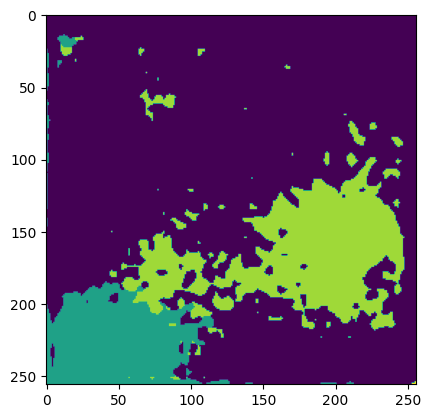

In [12]:
class MultiNet(nn.Module):
    def __init__(self, numberClass):
        super().__init__()
        _resnet34 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        self.backbone = create_feature_extractor(
            _resnet34,
            {
                # "relu": "feat1",
                "layer1": "feat2",
                "layer2": "feat3",
                "layer3": "feat4",
                "layer4": "feat5",
            },
        )

        with torch.no_grad():
            outputs_prediction = self.backbone(torch.rand([1, 3, 256, 256])).values()
            backbone_dimensions = [output.size(1) for output in outputs_prediction]

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.upsampling_2x_bilinear = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsampling_4x_bilinear = nn.UpsamplingBilinear2d(scale_factor=4)
        self.upsampling_8x_bilinear = nn.UpsamplingBilinear2d(scale_factor=8)
        self.conv5_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-1],
            out_channels=256,
            kernel_size=1,
        )
        self.conv5_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv5_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )
        self.conv4_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-2],
            out_channels=256,
            kernel_size=1,
        )
        self.conv4_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv4_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )
        self.conv3_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-3],
            out_channels=256,
            kernel_size=1,
        )
        self.conv3_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv3_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )
        self.conv2_1x1 = nn.Conv2d(
            in_channels=backbone_dimensions[-4],
            out_channels=256,
            kernel_size=1,
        )
        self.conv2_3x3_1 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=3,
            padding=1,
        )
        self.conv2_3x3_2 = nn.Conv2d(
            in_channels=128,
            out_channels=numberClass,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x):
        backbone_output = self.backbone(x)
        feat2, feat3, feat4, feat5 = (
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )

        conv5_mid = self.conv5_1x1(feat5).relu()
        conv5_prediction = self.conv5_3x3_1(conv5_mid).relu()
        conv5_prediction = self.conv5_3x3_2(conv5_prediction)

        conv4_lateral = self.conv4_1x1(feat4).relu()
        conv4_mid = conv4_lateral + self.upsampling_2x_bilinear(conv5_mid)
        conv4_prediction = self.conv4_3x3_1(conv4_mid).relu()
        conv4_prediction = self.conv4_3x3_2(conv4_prediction)

        conv3_lateral = self.conv3_1x1(feat3).relu()
        conv3_mid = conv3_lateral + self.upsampling_2x_bilinear(conv4_mid)
        conv3_prediction = self.conv3_3x3_1(conv3_mid).relu()
        conv3_prediction = self.conv3_3x3_2(conv3_prediction)

        conv2_lateral = self.conv2_1x1(feat2).relu()
        conv2_mid = conv2_lateral + self.upsampling_2x_bilinear(conv3_mid)
        conv2_prediction = self.conv2_3x3_1(conv2_mid).relu()
        conv2_prediction = self.conv2_3x3_2(conv2_prediction)

        final_prediction_5 = self.upsampling_8x_bilinear(conv5_prediction)
        final_prediction_4 = self.upsampling_4x_bilinear(conv4_prediction)
        final_prediction_3 = self.upsampling_2x_bilinear(conv3_prediction)
        final_prediction_2 = conv2_prediction

        return self.upsampling_4x_bilinear(
            final_prediction_5
            + final_prediction_4
            + final_prediction_3
            + final_prediction_2
        )


model = MultiNet(8)

with torch.no_grad():
    model.eval()
    output = model(torch.rand([8, 3, 256, 256]))
    print(output.size(), output.min(), output.max())
    plt.imshow(torch.argmax(output[0], dim=0) / 7)

In [ ]:
class UAVIDDataset4K(Dataset):
    def __init__(self, path, is_train=True):
        directory = Path(path)
        if is_train:
            self.images = [
                str(x.absolute()) for x in directory.glob("uavid_train/**/Images/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("uavid_train/**/Labels/*.png")
            ]
        else:
            self.images = [
                str(x.absolute()) for x in directory.glob("uavid_val/**/Images/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("uavid_val/**/Labels/*.png")
            ]

        if len(self.images) is not len(self.labels):
            print("Number of images & label are not the same.")
            return

    def __len__(self):
        return len(self.images)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path)

    @staticmethod
    def resize_image(image):
        resizer = Resize([2160, 3840], antialias="True")
        return resizer(image)

    @staticmethod
    def label_0and1(label):
        return label.type(torch.float32)

    @staticmethod
    def image_0and1(image):
        return (image / 255).type(torch.float32)

    @staticmethod
    def mask_label(label):
        labels = []
        labels.append((label[0] == 0) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 64) & (label[2] == 128))
        labels.append((label[0] == 0) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 64) & (label[1] == 0) & (label[2] == 128))
        labels.append((label[0] == 192) & (label[1] == 0) & (label[2] == 192))
        labels.append((label[0] == 64) & (label[1] == 64) & (label[2] == 0))
        return torch.stack(labels)

    def __getitem__(self, index):
        image = self.decode_image(self.images[index])
        image = self.resize_image(image)
        image = self.image_0and1(image)

        label = self.decode_image(self.labels[index])
        label = self.resize_image(label)
        label = self.label_0and1(label)
        label = self.mask_label(label)

        return image, label

In [ ]:
class UAVIDDataset(Dataset):
    def __init__(self, path, is_train=True):
        directory = Path(path)
        if is_train:
            self.images = [
                str(x.absolute()) for x in directory.glob("train/image/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("train/label/*.png")
            ]
        else:
            self.images = [
                str(x.absolute()) for x in directory.glob("test/image/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("test/label/*.png")
            ]

        if len(self.images) != len(self.labels):
            print("Number of images & label are not the same.")
            return

    def __len__(self):
        return len(self.images)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path)

    @staticmethod
    def resize_image(image):
        resizer = Resize([2160, 3840], antialias="True")
        return resizer(image)

    @staticmethod
    def label_0and1(label):
        return label.type(torch.float32)

    @staticmethod
    def image_0and1(image):
        return (image / 255).type(torch.float32)

    @staticmethod
    def mask_label(label):
        labels = []
        labels.append((label[0] == 0) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 64) & (label[2] == 128))
        labels.append((label[0] == 0) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 64) & (label[1] == 0) & (label[2] == 128))
        labels.append((label[0] == 192) & (label[1] == 0) & (label[2] == 192))
        labels.append((label[0] == 64) & (label[1] == 64) & (label[2] == 0))
        return torch.stack(labels)

    def __getitem__(self, index):
        image = self.decode_image(self.images[index])
        i, j, h, w = RandomCrop.get_params(image, (256, 256))
        image = self.image_0and1(image)
        label = self.decode_image(self.labels[index])
        label = self.mask_label(label)
        label = self.label_0and1(label)

        # Crop image and label
        image = crop(image, i, j, h, w)
        label = crop(label, i, j, h, w)

        return image, label

In [ ]:
dataset_labels = [
    "background",
    "building",
    "road",
    "tree",
    "vegetation",
    "moving_car",
    "stationary_car",
    "human",
]

In [ ]:
def combine_channels(image: torch.Tensor, colors: np.ndarray, is_predict: bool):
    _, _, h, w = image.shape
    output_image = np.zeros([h, w, 3], dtype=np.uint8)
    for i in range(colors.shape[0]):
        if is_predict:
            mask = image[0, i] > 0.5
        else:
            mask = image[0, i] == 1
        output_image[mask] = colors[i]
    return output_image


def visualize(
    input_image: torch.Tensor,
    grouth_truth: torch.Tensor,
    predicted: torch.Tensor,
):
    colors = np.array(
        [
            [0, 0, 0],
            [128, 0, 0],
            [128, 64, 128],
            [0, 128, 0],
            [128, 128, 0],
            [64, 0, 128],
            [192, 0, 192],
            [0, 0, 128],
        ],
        dtype=np.uint8,
    )
    fig, axes = plt.subplots(1, 3, figsize=(16, 9), dpi=200)
    legend_patches = [
        patches.Patch(
            color=np.concatenate([color / 255, [1]]),
            label=dataset_labels[idx],
        )
        for idx, color in enumerate(colors)
    ]
    fig.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5))

    grouth_truth_image = combine_channels(grouth_truth, colors, False)
    predicted_image = combine_channels(predicted, colors, True)
    input_image = torch.permute(input_image[0], [1, 2, 0])

    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()

    axes[0].set_title('Input Image')
    axes[1].set_title('Grouth Truth Image')
    axes[2].set_title('Predicted Image')

    axes[0].imshow(input_image)
    axes[1].imshow(grouth_truth_image)
    axes[2].imshow(predicted_image)

In [ ]:
# training_data = UAVIDDataset4K(path="data/uavid_v1.5_official_release_image", is_train=True)
training_data = UAVIDDataset(
    path="/Users/babi/Programs/high_performance_analysis_system/data/processed_dataset/",
    is_train=True,
)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
train_feature, train_label = next(iter(train_dataloader))

visualize(train_feature, train_label, train_label)

In [ ]:
class UNETNetwork(nn.Module):
    def __init__(self, numberClass):
        super().__init__()
        _resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = create_feature_extractor(
            _resnet50,
            {
                "layer1": "feat2",
                "layer2": "feat3",
                "layer3": "feat4",
                "layer4": "feat5",
            },
        )
        self.upsampling_2x_bilinear = nn.Upsample(scale_factor=2, mode="bilinear")
        self.conv5 = nn.Conv2d(
            in_channels=2048, out_channels=1024, kernel_size=3, padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=1024, out_channels=512, kernel_size=3, padding=1
        )
        self.conv7 = nn.Conv2d(
            in_channels=512, out_channels=256, kernel_size=3, padding=1
        )
        self.conv8 = nn.Conv2d(
            in_channels=256, out_channels=128, kernel_size=3, padding=1
        )
        self.convfinal = nn.Conv2d(
            in_channels=128, out_channels=numberClass, kernel_size=1
        )

    def forward(self, x):
        # with profiler.record_function("BACKBONE"):
        backbone_output = self.backbone(x)

        feat2, feat3, feat4, feat5 = (
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )

        # with profiler.record_function("FRONTEND"):
        feat4to6 = self.upsampling_2x_bilinear(self.conv5(feat5).relu())
        feat3to7 = self.upsampling_2x_bilinear(self.conv6(feat4 + feat4to6).relu())
        feat2to8 = self.upsampling_2x_bilinear(self.conv7(feat3 + feat3to7).relu())
        featout = self.upsampling_2x_bilinear(self.conv8(feat2 + feat2to8).relu())

        return self.upsampling_2x_bilinear(self.convfinal(featout))


model = UNETNetwork(8).to('mps')
thisinput = torch.rand(1, 3, 256, 256, device='mps')
model(thisinput)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out = model(thisinput)

print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))


In [ ]:
class FPNNetwork(nn.Module):
    def __init__(self, numberClass):
        super().__init__()
        _resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = create_feature_extractor(
            _resnet50,
            {
                "relu": "feat1",
                "layer1": "feat2",
                "layer2": "feat3",
                "layer3": "feat4",
                "layer4": "feat5",
            },
        )
        self.upsampling_2x_bilinear = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsampling_4x_bilinear = nn.UpsamplingBilinear2d(scale_factor=4)
        self.upsampling_8x_bilinear = nn.UpsamplingBilinear2d(scale_factor=8)
        self.upsampling_16x_bilinear = nn.UpsamplingBilinear2d(scale_factor=16)
        # self.conv5 = nn.Conv2d(
        #     in_channels=2048, out_channels=64, kernel_size=3, padding=1
        # )
        self.conv5 = nn.Conv2d(
            in_channels=2048, out_channels=256, kernel_size=3, padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=1024, out_channels=512, kernel_size=3, padding=1
        )
        self.conv7 = nn.Conv2d(
            in_channels=512, out_channels=256, kernel_size=3, padding=1
        )
        self.conv8 = nn.Conv2d(
            in_channels=256, out_channels=128, kernel_size=3, padding=1
        )
        # self.convfinal = nn.Conv2d(
        #     in_channels=64, out_channels=numberClass, kernel_size=1
        # )
        self.convfinal = nn.Conv2d(
            in_channels=256, out_channels=numberClass, kernel_size=1
        )

    def forward(self, x):
        backbone_output = self.backbone(x)
        feat1, feat2, feat3, feat4, feat5 = (
            backbone_output["feat1"],
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )

        # print(feat1.size())
        # print(feat2.size())
        # print(feat3.size())
        # print(feat4.size())
        # print(feat5.size())

        # return self.upsampling_2x_bilinear(
        #     self.convfinal(self.upsampling_16x_bilinear(self.conv5(feat5)) + feat1)
        # )

        return self.upsampling_4x_bilinear(
            self.convfinal(self.upsampling_8x_bilinear(self.conv5(feat5)) + feat2)
        )

        # feat4to6 = self.upsampling_2x_bilinear(self.conv5(feat5).relu())
        # feat3to7 = self.upsampling_2x_bilinear(self.conv6(feat4 + feat4to6).relu())
        # feat2to8 = self.upsampling_2x_bilinear(self.conv7(feat3 + feat3to7).relu())
        # featout = self.upsampling_2x_bilinear(self.conv8(feat2 + feat2to8).relu())
        # return self.upsampling_2x_bilinear(self.convfinal(featout))


model = FPNNetwork(8)
with torch.no_grad():
    print(model(torch.rand(1, 3, 256, 256)).size())

In [ ]:
def dice_index(
    pred: torch.Tensor,
    target: torch.Tensor,
    epsilon=1e-9,
):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    nominator = 2 * torch.matmul(pred_flat, target_flat)
    denominator = torch.sum(pred_flat) + torch.sum(target_flat)
    return (nominator + epsilon) / (denominator + epsilon)


def dice_index_per_channel(
    pred: torch.Tensor,
    target: torch.Tensor,
    epsilon=1e-9,
):
    pred_flat = pred.permute([1, 0, 2, 3]).flatten(1)
    label_flat = target.permute([1, 0, 2, 3]).flatten(1)
    nominator = 2 * torch.sum(pred_flat * label_flat, dim=1)
    denominator = torch.sum(pred_flat, dim=1) + torch.sum(label_flat, dim=1)
    return (nominator + epsilon) / (denominator + epsilon)


def total_loss(pred: torch.Tensor, target: torch.Tensor):
    crossentropy_loss = torch.nn.functional.cross_entropy(pred, target)
    dice_loss = 1 - dice_index(pred.softmax(1), target)
    return crossentropy_loss + dice_loss

In [ ]:
training_data = UAVIDDataset(
    path="/Users/babi/Programs/high_performance_analysis_system/data/processed_dataset/",
    is_train=True,
)
train_dataloader = DataLoader(
    training_data,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
)
model = FPNNetwork(numberClass=8).to("mps")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to("mps")
timestamp = datetime.datetime.now().strftime(r"%Y%m%d_%H%M%S")
writer = SummaryWriter("data/training/train_{}".format(timestamp))

In [ ]:
# model.load_state_dict(torch.load('data/savedmodel/49_model.pt', map_location=torch.device('cpu')))

In [ ]:
for epoch in range(50):
    model.train(True)
    running_loss = 0.0
    running_dice = np.zeros(8)
    for idx, data in enumerate(tqdm(train_dataloader)):
        inputs: torch.Tensor
        labels: torch.Tensor
        inputs, labels = data
        optimizer.zero_grad()

        inputs = inputs.to("mps")
        labels = labels.to("mps")

        inputs = normalize(inputs)
        outputs = model(inputs)

        loss = total_loss(outputs, labels)
        loss.backward()
        
        dice_per_channel = dice_index_per_channel(outputs.softmax(1), labels)
        optimizer.step()
        running_loss += loss.item()
        running_dice += dice_per_channel.tolist()

        if idx % 100 == 99:
            current_training_sample = epoch * len(train_dataloader) + idx + 1
            current_dice = running_dice / 100
            writer.add_scalar("Loss/train", running_loss / 100, current_training_sample)
            writer.add_scalars(
                "dice/train",
                {name: current_dice[i] for i, name in enumerate(dataset_labels)},
                current_training_sample,
            )
            print(f"Loss: {running_loss / 100}")
            running_loss = 0.0
            running_dice *= 0

In [ ]:
# torch.save(model, "model.pt")

In [ ]:
model.eval()
test_data = UAVIDDataset(
    path="/Users/babi/Programs/high_performance_analysis_system/data/processed_dataset/",
    is_train=False,
)
test_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)
test_feature, test_label = next(iter(test_dataloader))

with torch.no_grad():
    outputs = model(normalize(test_feature.to("mps")))
    outputs = outputs.to("cpu").softmax(axis=1)
    visualize(test_feature, test_label, outputs)